This project is greatly inspired by the following article:

[Building a full-text search engine in 150 lines of Python code](https://bart.degoe.de/building-a-full-text-search-engine-150-lines-of-code/)

and the Information Retrieval and Web Search lectures at the University of Mannheim, Germany

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# ! pip install datasets
# ! pip install gensim 
# ! pip install nltk
# ! pip install tqdm

In [2]:
%%time
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

from model_utils import tf, idf, unigram, doc_embed, cluster_docs, wd, opt_svd 
from search_models import Boolean, Vsm, Bim, BimExt, QueryLklhd, W2Vsm, Lsi
from search import searching 
from saveload import indexing
from indices import SubInvertedIndex
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import pandas as pd

import gensim
import gensim.downloader as api

CPU times: user 45 µs, sys: 25 µs, total: 70 µs
Wall time: 73.9 µs


# Indexing the documents collection

In [3]:
%%time
inverted_index_sortpost=indexing(dataset="ms_marco", save=True, save_load_path="./data", index_type='inv')

.....................Collection indexation in progress.....................


Reusing dataset ms_marco (/home/georges_sarr/.cache/huggingface/datasets/ms_marco/v1.1/1.1.0/b6a62715fa5219aea5275dd3556601004cd63945cb63e36e022f77bb3cbbca84)
100%|██████████| 9650/9650 [00:41<00:00, 229.94it/s]


.....................Successfully saved the index.....................
CPU times: user 45.4 s, sys: 1.19 s, total: 46.6 s
Wall time: 47.5 s


In [4]:
# TAKES TOO MUCH TIME TO RUN >= 10 minutes
# %%time
# positional_index_sortpost=indexing(dataset="ms_marco", save=True, save_load_path="./data", index_type="pos")

# Statistics

In [5]:
print(f"The vocabulary is made of {len(inverted_index_sortpost.index)} words")

The vocabulary is made of 132161 words


### Document lengths

There are 79176 documents


<AxesSubplot:ylabel='Count'>

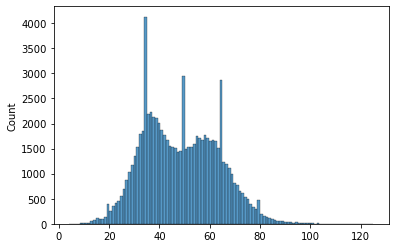

In [10]:
print(f"There are {len(inverted_index_sortpost.documents)} documents")
doc_lenghts=[len(inverted_index_sortpost.raw_freq[ID]) for ID in inverted_index_sortpost.documents]
sb.histplot(doc_lenghts)

In [11]:
round(pd.DataFrame({"doc_lengths": doc_lenghts}).describe(),0)

,doc_lengths
count,79176.0
mean,49.0
std,15.0
min,4.0
25%,37.0
50%,48.0
75%,60.0
max,125.0


### Word raw frequencies

In [12]:
# average number of time each token appears in a document
avg_raw_freqs = [np.mean([inverted_index_sortpost.raw_freq[ID][term] for ID in inverted_index_sortpost.index[term]]) for term in inverted_index_sortpost.index]
round(pd.DataFrame({"avg_raw_freqs":avg_raw_freqs}).describe(),0)

,avg_raw_freqs
count,132161.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,24.0


Most of the terms appear just once in a document.

### Document frequencies

In [13]:
%%time 
doc_freqs=[len(inverted_index_sortpost.index[token]) for token in inverted_index_sortpost.index]
round(pd.DataFrame({"doc_freqs": doc_freqs}).describe(),0)

CPU times: user 102 ms, sys: 187 µs, total: 102 ms
Wall time: 102 ms


,doc_freqs
count,132161.0
mean,29.0
std,571.0
min,1.0
25%,1.0
50%,2.0
75%,5.0
max,73633.0


A term appears on average in 30 $\pm$ 500 documents, 75% of the terms appear in less than 5 documents (a lot of rare terms, weird ??). Lets try to visualize why

In [14]:
for pos , term in enumerate(inverted_index_sortpost.index) : 
    if pos<=500 and len(inverted_index_sortpost.index[term])<=5: print(term) 

stink
relocate
scatter
deters
npr
contributory
coaltake
fuelsoil
circumscribes
apothems
4cm
polygonsproperties
incircle
congruent
equilateral
weisstein
mathworld
sagitta
inradius
hypotenuse


It looks plausible when we look at the above sequence of words (they look rare indeed)

# Preparing for search

### TF-IDF and language model

In [6]:
tfreqs, idfs, unigram_model=tf(inverted_index_sortpost), idf(inverted_index_sortpost), unigram(inverted_index_sortpost)

### Uploading word2vec model

In [7]:
## Takes up to 10 minutes to run, but TO RUN ONCE !!!
# path = api.load("word2vec-google-news-300", return_path=True)
path="~/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz"
# Takes up to 1 minute to load the google news word2vec model
w2v = gensim.models.KeyedVectors.load_word2vec_format(path, binary=True)
print(f"Word2Vec model vocabulary size = {len(w2v.key_to_index)} words")

Word2Vec model vocabulary size = 3000000 words


### Document embedding and document clustering

In [8]:
doc2vec=doc_embed(inverted_index_sortpost, tfreqs, idfs, w2v)

100%|██████████| 79176/79176 [00:19<00:00, 3963.81it/s]


Computing K-means model for different values of K


100%|██████████| 6/6 [07:49<00:00, 78.19s/it]


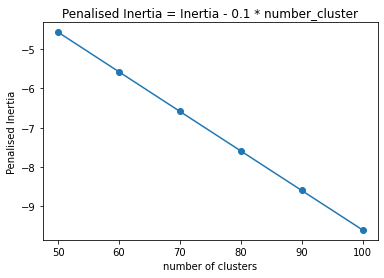

In [59]:
doc_kmeans=cluster_docs(inverted_index_sortpost, doc_embeds=doc2vec,num_min_centr=50,num_max_centr=110,step=10,plot=True)

### Random subsample of the index (for latent semantic indexing (lsi) model)

In [9]:
sub_inv = SubInvertedIndex()
nb_docs=len(inverted_index_sortpost.documents)
nb_sampled_docs=1000
sampled_docs=np.random.choice(a=range(1,nb_docs+1),size=nb_sampled_docs, replace=False)
sub_inv.reindex(inverted_index_sortpost, sampled_docs)

100%|██████████| 1000/1000 [00:00<00:00, 698236.06it/s]


In [10]:
WD, wtoi, dtoi = wd(sub_inv)
WD.shape

1000it [00:00, 17582.13it/s]


(11652, 1000)

Computing SVDs for different values of k


100%|██████████| 9/9 [01:02<00:00,  6.95s/it]


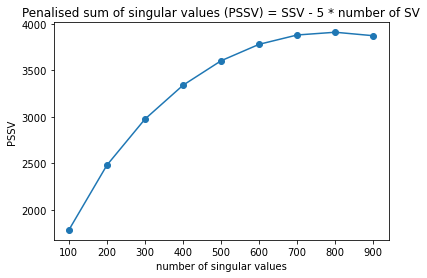

In [11]:
svd_mats=opt_svd(WD,min_k=100,max_k=1000,step_k=100, penalty=5,plot=True)

# Searching

### Simple boolean retrieval

In [12]:
bl=Boolean(index=inverted_index_sortpost, query_type="AND", correct_query=True)
searching(bl)

Did you mean: chat is mids ?


Your query:  what is AIDS ?

Result(s): 
Document(ID=36036, content='What is mean by opportunistic infection-Two examples of opportunistic infections are given below. In day to day life we unknowingly carry out many germs such as, fungi, bacteria, protozoa and viruses. When a person is HIV infection free the immune system resists such invaders. It controls them properly. Examples of Opportunistic Infection. Before going to see the examples of opportunistic infection, it would be better to learn that what is HIV and how it helps such infections to attack on the immune system. HIV is known as Human Immuno Deficiency Virus. The virus leads to develop the AIDS. It attacks on the CD4 cells') 

Document(ID=36038, content='Examples of opportunistic infections are given here for your sake. You can get the list of such examples in the given article. Moreover you would be able to know that what is opportunistic infection and how it leads a person to the life threat

In [37]:
# OLD
# searching(index=inverted_index_sortpost, modl='bool', top=3, query_type='AND') # example what is AIDS

## Phrase queries retrieval PENDING( POSITIONAL INDEXING TAKES TIME TO RUN DUE TO PREPROCESSING)

In [14]:
# %%time
# query='''the effects of humidity on the mach number and static pressure in the
# working section were investigated and the results are compared with
# theoretical estimates at a nominal mach number 2.0'''
# phrase_retrieval(positional_index_sortpost, query)

### Vector Space Model

In [17]:
vsm=Vsm(index=inverted_index_sortpost, tfreqs=tfreqs, idfs=idfs, top=5, correct_query=False)
searching(vsm)

Your query:  what is AIDS ?

Result(s): 
(Document(ID=37738, content='Uses. Famotidine is used to help reduce the amount of stomach acid produced. It aids in the treatment of stomach ulcers that are present and helps prevent ulcer formation. '), 'score = 0.9180889905564791') 

(Document(ID=36038, content='Examples of opportunistic infections are given here for your sake. You can get the list of such examples in the given article. Moreover you would be able to know that what is opportunistic infection and how it leads a person to the life threatening disease that is AIDS. Examples of Opportunistic Infection. Before going to see the examples of opportunistic infection, it would be better to learn that what is HIV and how it helps such infections to attack on the immune system. HIV is known as Human Immuno Deficiency Virus. The virus leads to develop the AIDS. It attacks on the CD4 cells'), 'score = 0.8149428146260839') 

(Document(ID=41258, content='Uses of This Medicine. Tenofovir is us

In [39]:
# OLD
# searching(index=inverted_index_sortpost, modl='tf_idf',tfreqs= tfreqs, idfs=idfs, top=3)

### Binary Independence models

In [19]:
bim=Bim(index=inverted_index_sortpost , top=3, correct_query=True)
searching(bim)

Did you mean: chat is franc ?


Your query:  what is Franc ?

Result(s): 
(Document(ID=7493, content='[fʁɑ̃] ; sign: F or Fr), also commonly distinguished as the French franc (FF), was a currency of France. Between 1360 and 1641, it was the name of coins worth 1 livre tournois and it remained in common parlance as a term for this amount of money. It was reintroduced (in decimal form) in 1795. It was revalued in 1960, with each new franc (NF) being worth 100 old francs.'), 'score = 3.5975635615929686') 

(Document(ID=77924, content="By the end of the 20th century, the United States dollar was considered the world's most dominant reserve currency, and the world's need for dollars has allowed the United States government as well as Americans to borrow at lower costs, granting them an advantage in excess of $100 billion per year. The Swiss franc, despite gaining ground among the world's foreign-currency reserves and being often used in denominating foreign loans, cannot be considered as a 

### Improving with some extensions

In [29]:
two_poisson=BimExt(index=inverted_index_sortpost, extension='two_poisson', top=3)
searching(two_poisson)

Your query:   what is Franc ?

Result(s): 
(Document(ID=7491, content="The currency of France before 2002 was the French Franc. The franc was abolished in 2002 and replaced by the Euro at the rate of €1 = 6.55957 francs. The subdivision of th … e franc was the centime, 1 franc = 100 centimes. The name 'centime' is also used in French for the subdivision of the Euro, €1 = 100 centimes.   France used the franc as its currency up till 2002. Confidence votes 55. The currency used in France is the Euro (symbol €) and its the subdivision is called the 'cent' (English) or 'centime' (French). The Euro replaced the French franc in 2002 at the rate of €1 = 6.55957 francs, and the franc was no longer redeemable after February 201"), 'score = 7.162864914762384') 

(Document(ID=7487, content='French currency conversion. The French Franc is no longer used as money in France, it is now the Euro. The value of the French Franc was fixed at 1 Euro = 6.55957 French Francs, or 1 French Franc = 0.152449017

In [61]:
# OLD
# searching(inverted_index_sortpost, modl='bim_ext', tfreqs=tfreqs, top=3, extension="two_poisson", k=1.5, b=0.75)

In [35]:
bm11=BimExt(index=inverted_index_sortpost, extension='bm11', top=5, k=1.5)
searching(bm11)

Your query:  what is Franc ?

Result(s): 
(Document(ID=7491, content="The currency of France before 2002 was the French Franc. The franc was abolished in 2002 and replaced by the Euro at the rate of €1 = 6.55957 francs. The subdivision of th … e franc was the centime, 1 franc = 100 centimes. The name 'centime' is also used in French for the subdivision of the Euro, €1 = 100 centimes.   France used the franc as its currency up till 2002. Confidence votes 55. The currency used in France is the Euro (symbol €) and its the subdivision is called the 'cent' (English) or 'centime' (French). The Euro replaced the French franc in 2002 at the rate of €1 = 6.55957 francs, and the franc was no longer redeemable after February 201"), 'score = 7.075626719547653') 

(Document(ID=7487, content='French currency conversion. The French Franc is no longer used as money in France, it is now the Euro. The value of the French Franc was fixed at 1 Euro = 6.55957 French Francs, or 1 French Franc = 0.1524490172

In [30]:
# OLD
# searching(inverted_index_sortpost, modl='bim_ext', tfreqs=tfreqs, top=3, extension="bm11", k=1.5, b=0.75)

In [36]:
bm25=BimExt(index=inverted_index_sortpost, extension='bm25', top=5, k=1.5, b=0.8)
searching(bm25)

Your query:  what is Franc ?

Result(s): 
(Document(ID=7491, content="The currency of France before 2002 was the French Franc. The franc was abolished in 2002 and replaced by the Euro at the rate of €1 = 6.55957 francs. The subdivision of th … e franc was the centime, 1 franc = 100 centimes. The name 'centime' is also used in French for the subdivision of the Euro, €1 = 100 centimes.   France used the franc as its currency up till 2002. Confidence votes 55. The currency used in France is the Euro (symbol €) and its the subdivision is called the 'cent' (English) or 'centime' (French). The Euro replaced the French franc in 2002 at the rate of €1 = 6.55957 francs, and the franc was no longer redeemable after February 201"), 'score = 7.092908779701432') 

(Document(ID=7487, content='French currency conversion. The French Franc is no longer used as money in France, it is now the Euro. The value of the French Franc was fixed at 1 Euro = 6.55957 French Francs, or 1 French Franc = 0.1524490172

In [32]:
# OLD
# searching(inverted_index_sortpost, modl='bim_ext', tfreqs=tfreqs, top=3, extension="bm25", k=1.5, b=0.75)

### Language model

In [63]:
ql=QueryLklhd(index=inverted_index_sortpost, lang_model=unigram_model, top=3, correct_query=True)
searching(ql)

Did you mean: lave the world ?


Your query:  Save the world !!!

Result(s): 
(Document(ID=1, content='We have been feeding our back yard squirrels for the fall and winter and we noticed that a few of them have missing fur. One has a patch missing down his back and under both arms. Also another has some missing on his whole chest. They are all eating and seem to have a good appetite.'), 'score = 0.060670768902718046') 

(Document(ID=2, content='Critters cannot stand the smell of human hair, so sprinkling a barrier of hair clippings around your garden, or lightly working it into the soil when you plant bulbs, apparently does have some merit. The whole thing kind of makes me laugh. It never occurred to me that we are the ones that stink.'), 'score = 0.060670768902718046') 

(Document(ID=3, content="Spread some human hair around your vegetable and flower gardens. This will scare the squirrels away because humans are predators of squirrels. It is better if the hair hasn't been washed so th

In [37]:
# example  Save the world !!!
# OLD
# searching(inverted_index_sortpost, modl='query_lklh', top=5, lang_model=unigram_model)

### Word2Vec Vector Space model

In [58]:
# Not clustering the documents before hand takes up to 10 seconds

w2vvsm_np=W2Vsm(index=inverted_index_sortpost, idfs=idfs, word_embeds=w2v, doc_embeds=doc2vec, precluster=False)
searching(w2vvsm_np)

100%|██████████| 79176/79176 [00:09<00:00, 8110.84it/s]


Your query:  What is AIDS ?

Result(s): 
(Document(ID=46456, content='Physical therapist assistants (PTAs) work as part of a dynamic healthcare team. Assistants help physical therapists maintain therapy facilities and monitor patient progress, while also helping patients by assisting them on difficult movements and instructing them on how to use walking aids. '), 'score = 0.5851810300657312') 

(Document(ID=31466, content="Biofeedback sessions are typically done in a therapist's office, but there are computer programs that connect the biofeedback sensor to your own computer. A biofeedback therapist helps you practice relaxation exercises, which you fine-tune to control different body functions. Researchers aren't exactly sure how or why biofeedback works. They do know that biofeedback promotes relaxation, which can help relieve a number of conditions that are related to stress. During a biofeedback session, electrodes are attached to your skin. Finger sensors can also be used. These el

In [46]:
# OLD
# searching(inverted_index_sortpost, modl='w2v_vsm',tfreqs= tfreqs, idfs=idfs, top=5, \
#         word_embeds=w2v, doc_embeds=doc2vec, precluster=False)

In [65]:
w2vvsm_p=W2Vsm(index=inverted_index_sortpost, idfs=idfs, word_embeds=w2v, doc_embeds=doc2vec, precluster=True,
               cluster_centers=doc_kmeans.cluster_centers_, doc_cluster_labels=doc_kmeans.labels_, top_center=10)
searching(w2vvsm_p)

Your query:  what is AIDS ?

Result(s): 
(Document(ID=46456, content='Physical therapist assistants (PTAs) work as part of a dynamic healthcare team. Assistants help physical therapists maintain therapy facilities and monitor patient progress, while also helping patients by assisting them on difficult movements and instructing them on how to use walking aids. '), 'score = 0.5851810300657312') 

(Document(ID=31466, content="Biofeedback sessions are typically done in a therapist's office, but there are computer programs that connect the biofeedback sensor to your own computer. A biofeedback therapist helps you practice relaxation exercises, which you fine-tune to control different body functions. Researchers aren't exactly sure how or why biofeedback works. They do know that biofeedback promotes relaxation, which can help relieve a number of conditions that are related to stress. During a biofeedback session, electrodes are attached to your skin. Finger sensors can also be used. These el

In [64]:
# OLD
# searching(inverted_index_sortpost, modl='w2v_vsm',tfreqs= tfreqs, idfs=idfs, top=5, \
#         word_embeds=w2v, doc_embeds=doc2vec, precluster=True, cluster_centers=doc_kmeans.cluster_centers_, \
#         doc_cluster_labels=doc_kmeans.labels_,top_center=10)

### Latent semantic indexing

In [79]:
lsi=Lsi(index=sub_inv, idfs=idfs, top=3, svd_word_doc_mat=svd_mats, dtoi=dtoi, wtoi=wtoi)
searching(lsi)

Your query:  save the world !!

Result(s): 
(Document(ID=42666, content='≈ 1 Comment. The Mayas believed in a world of three layers: Heaven, the middle world, and underworld. Its roots were in the underworld, its trunk in the middle world, and its branches in the highest layer of the other world. The tree represents the Milky Way. To the Maya, the universe created in this order: First came the earth and the seas, then animals.'), 'score = 0.3115682659706447') 

(Document(ID=51042, content='Top Thrill Dragster opened in 2003 as the tallest and fastest roller coaster in the world. Despite no longer being the tallest or fastest coaster in the world, Dragster still thrills riders by offering an incredible launch, huge tophat, and blazing speeds-all with lapbars.'), 'score = 0.2876844261988697') 

(Document(ID=46004, content='How you handle the fact that there is another man or woman has a great deal to do with whether or not you end up in divorce court or, are able to save your marriage. I

In [80]:
# OLD
# searching(sub_inv, modl='lsi', idfs=idfs, top=5, \
#          svd_word_doc_mat=svd_mats, wtoi=wtoi, dtoi=dtoi)

# Evaluation